### Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import string
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets
from ipywidgets import interact

plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('fivethirtyeight')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

ModuleNotFoundError: No module named 'numpy'

### Reading the Data

In [ ]:
# reading the Dataset
data = pd.read_csv('drug.csv')

# lets print the shape of the dataset
print("The Shape of the Dataset :", data.shape)

The Shape of the Dataset : (161297, 7)


In [ ]:
# lets check the head of the dataset
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [ ]:
# lets Explore Some of the Important Column in the dataset

print("Number of Unique Drugs present in the Dataset :", data['drugName'].nunique())
print("Number of Unique Medical Conditions present in the Dataset :", data['condition'].nunique())

print("\nThe Time Period of Collecting the Data")
print("Starting Date :", data['date'].min())
print("Ending Date :", data['date'].max())

Number of Unique Drugs present in the Dataset : 3436
Number of Unique Medical Conditions present in the Dataset : 884

The Time Period of Collecting the Data
Starting Date : 1-Apr-08
Ending Date : 9-Sep-17


### Summarizing the Dataset

In [ ]:
# lets summarize the Dataset
data[['rating','usefulCount']].describe()

,rating,usefulCount
count,161297.000000,161297.000000
mean,6.994377,28.004755
std,3.272329,36.403742
min,1.000000,0.000000
25%,5.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,1291.000000


In [ ]:
# lets check the Number and Name of the Drugs with 0 Useful Count in Details
print("Analysis on Useless Drugs")
print("----------------------------")
print("The Number of Drugs with No Useful Count :", data[data['usefulCount'] == 0].count()[0])

# Lets Check the Number of Drugs with No Usesful Count with Review Greater than or Equal to 8
print("Number of Good Drugs with Lesser Useful Count :", data[(data['usefulCount'] == 0) &
                                                data['rating'] >= 8].count()[0])

# Lets Check the Average Rating of the Drugs with No Useful Count
print("Average Rating of Drugs with No Useful Count : {0:.2f}".format(data[data['usefulCount'] == 0]['rating'].mean()))

print("\nAnalysis on Useful Drugs")
print("----------------------------")
print("The Number of Drugs with Greater than 1000 Useful Counts :", data[data['usefulCount'] > 1000].count()[0])
print("Average Rating of Drugs with 1000+ Useful Counts :", data[data['usefulCount'] > 1000]['rating'].mean())
print("\nName and Condition of these Drugs: \n\n", 
    data[data['usefulCount'] > 1000][['drugName','condition']].reset_index(drop = True))

Analysis on Useless Drugs
----------------------------
The Number of Drugs with No Useful Count : 6318
Number of Good Drugs with Lesser Useful Count : 0
Average Rating of Drugs with No Useful Count : 5.80

Analysis on Useful Drugs
----------------------------
The Number of Drugs with Greater than 1000 Useful Counts : 4
Average Rating of Drugs with 1000+ Useful Counts : 10.0

Name and Condition of these Drugs: 

          drugName      condition
0          Mirena  Birth Control
1      Sertraline     Depression
2  Levonorgestrel  Birth Control
3          Zoloft     Depression


In [ ]:
# lets summarize Categorical data also
data[['drugName','condition','review']].describe(include = 'object')

,drugName,condition,review
count,161297,160398,161297
unique,3436,884,112329
top,Levonorgestrel,Birth Control,"""Good"""
freq,3657,28788,33


In [ ]:
# lets check for Missing Values
data.isnull().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [ ]:
# as we know that condition is an Important Column, so we will delete all the records where Condition is Missing
data = data.dropna()

# lets check the Missing values now
data.isnull().sum().sum()

0

### Unveiling Hidden Patterns from the Data

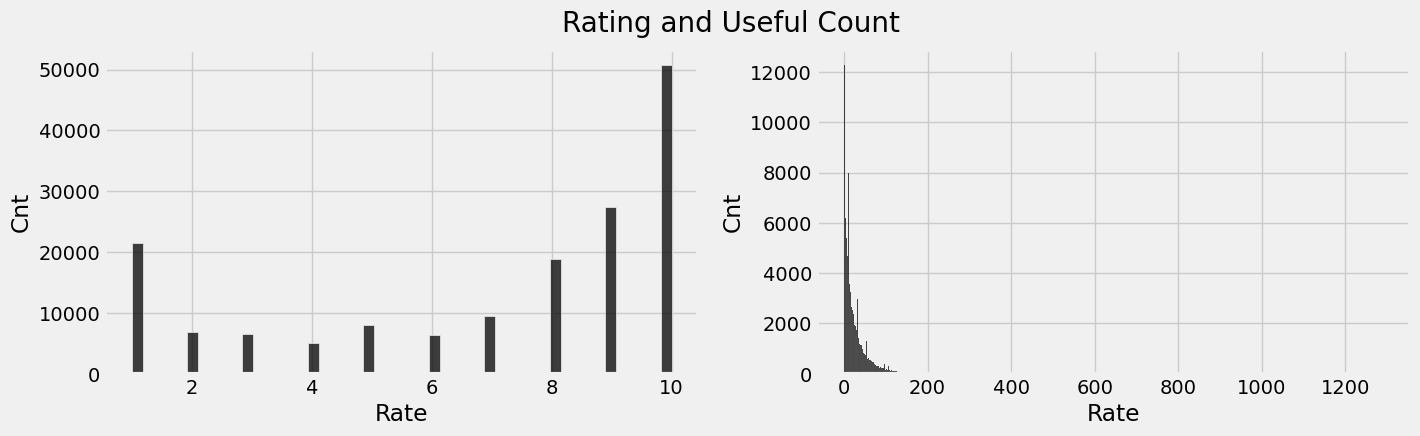

In [ ]:
# lets check the Distribution of Rating and Useful Count

plt.rcParams['figure.figsize'] = (15, 4)

plt.subplot(1, 2, 1)
ax=sns.histplot(data['rating'],color="Black")
ax.set(xlabel="Rate",ylabel="Cnt")
plt.subplot(1, 2, 2)
bx=sns.histplot(data['usefulCount'],color="Black")
bx.set(xlabel="Rate",ylabel="Cnt")
plt.suptitle('Rating and Useful Count \n ', fontsize = 20)
plt.show()

In [ ]:
# Checking whether Length of Review has any Impact on Ratings of the Drugs

# for that we need to create a new column to calculate length of the reviews
data['len']  = data['review'].apply(len)

In [ ]:
# lets check the Impact of Length of Reviews on Ratings
data[['rating','len']].groupby(['rating']).agg(['min','mean','max'])

len                   
       min        mean    max
rating                       
1        5  428.784505   3692
2        9  452.902893  10787
3        8  461.249961   5112
4        7  464.077912   3030
5        6  477.982661   2048
6        4  467.957150   2202
7        6  485.597765   3063
8        3  483.584163   4087
9        3  477.696117   6182
10       3  443.215923   6192

### Cleaning the Reviews

In [ ]:
# as it is clear that the reviews have so many unnecassry things such as Stopwords, Punctuations, numbers etc

# First lets remove Punctuations from the Reviews
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

data['review'] = data['review'].apply(punctuation_removal)
print(data['review'])


0         It has no side effect I take it in combination...
1         My son is halfway through his fourth week of I...
2         I used to take another oral contraceptive whic...
3         This is my first time using any form of birth ...
4         Suboxone has completely turned my life around ...
                                ...                        
161292    I wrote my first report in MidOctober of 2014 ...
161293    I was given this in IV before surgey I immedia...
161294    Limited improvement after 4 months developed b...
161295    I039ve been on thyroid medication 49 years I s...
161296    I039ve had chronic constipation all my adult l...
Name: review, Length: 160398, dtype: object


In [ ]:
print(data['review'])

0         It has no side effect I take it in combination...
1         My son is halfway through his fourth week of I...
2         I used to take another oral contraceptive whic...
3         This is my first time using any form of birth ...
4         Suboxone has completely turned my life around ...
                                ...                        
161292    I wrote my first report in MidOctober of 2014 ...
161293    I was given this in IV before surgey I immedia...
161294    Limited improvement after 4 months developed b...
161295    I039ve been on thyroid medication 49 years I s...
161296    I039ve had chronic constipation all my adult l...
Name: review, Length: 160398, dtype: object


In [ ]:
# Now lets Remove the Stopwords also
#nltk.download("stopwords")
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download("stopwords")

stop = stopwords.words('english')
stop.append("i'm")

stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 

def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words ]

data['review'] = data['review'].apply(stopwords_removal)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tirth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tirth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# lets remove the Numbers also

import re
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

data['review'] = data['review'].apply(drop_numbers)

In [ ]:
from nltk import tokenize
token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    colors = sns.color_palette('pastel')[0:20]
    df_frequency.plot(kind='pie',autopct='%1.0f%%', shadow=True)
    plt.show()

In [ ]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,len
0,206461,Valsartan,Left Ventricular Dysfunction,side effect take combination bystolic mg fish oil,9,20-May-12,27,79
1,95260,Guanfacine,ADHD,son halfway fourth week intuniv became concern...,8,27-Apr-10,192,741
2,92703,Lybrel,Birth Control,used take another oral contraceptive pill cycl...,5,14-Dec-09,17,755
3,138000,Ortho Evra,Birth Control,first time using form birth control glad went ...,8,3-Nov-15,10,448
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone completely turned life around feel he...,9,27-Nov-16,37,719


TypeError: '<' not supported between instances of 'str' and 'int'

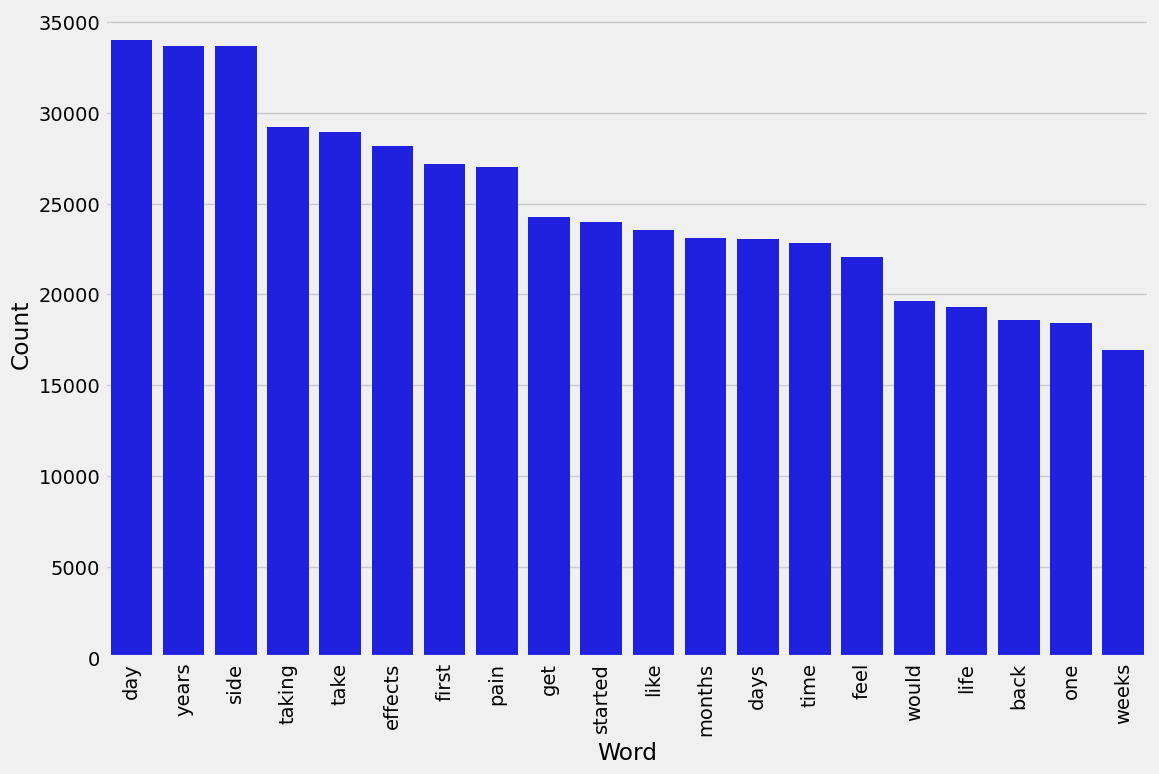

In [ ]:
counter(data[data["rating"] >= 8], "review", 20)

In [ ]:
# Split the data4
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data['review'], data.rating, test_size=0.2, random_state=42)

### Calculating the Sentiment from Reviews

In [ ]:
# for using Sentiment Analyzer we will have to dowload the Vader Lexicon from NLTK

import nltk
nltk.download('vader_lexicon')

In [ ]:
# lets calculate the Sentiment from Reviews

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

train_sentiments = []

for i in data['review']:
    train_sentiments.append(sid.polarity_scores(i).get('compound'))
    
train_sentiments = np.asarray(train_sentiments)
data['sentiment'] = pd.Series(data=train_sentiments)

In [ ]:
# lets check Impact of Sentiment on Reviews
data[['rating','sentiment']].groupby(['rating']).agg(['min','mean','max'])

### Calculating Effectiveness and Usefulness of Drugs

In [ ]:
# Lets Calculate an Effective Rating


min_rating = data['rating'].min()
max_rating = data['rating'].max()

def scale_rating(rating):
    rating -= min_rating
    rating = rating/(max_rating -1)
    rating *= 5
    rating = int(round(rating,0))
    
    if(int(rating) == 0 or int(rating)==1 or int(rating)==2):
        return 0
    else:
        return 1
    
data['eff_score'] = data['rating'].apply(scale_rating)

In [ ]:
# lets also calculate Usefulness Score

data['usefulness'] = data['rating']*data['usefulCount']*data['eff_score']

# lets check the Top 10 Most Useful Drugs with their Respective Conditions
data[['drugName','condition','usefulness']][data['usefulness'] > 
                            data['usefulness'].mean()].sort_values(by = 'usefulness', 
                                        ascending = False).head(10).reset_index(drop = True)

### Analyzing the Medical Condtitions

In [ ]:
# lets calculate the Number of Useless and Useful Drugs for Each Condition

@interact
def check(condition = list(data['condition'].value_counts().index)):
    return data[data['condition'] == condition]['eff_score'].value_counts()

In [ ]:
# lets check this in Graph, 

popular_conditions = ('Birth Control','Depression','Pain','Anxiety','Acne','Bipolar Disorde','Insomnia','Weight Loss',
                      'Obesity','ADHD', 'Diabetes, Type 2', 'Emergency Contraception', 'High Blood Pressure','Migrane')
conditions = data.loc[data['condition'].isin(popular_conditions)]

sns.barplot(x = conditions['condition'], y = conditions['rating'], hue = data['eff_score'], 
     palette = 'autumn')
plt.title('Conditions vs Effective Number of Drugs')
plt.xticks(rotation = 90)
plt.ylabel(' ')
plt.show()

In [ ]:
# lets check the Most Common Conditions

print("Number of Unique Conditions :", data['condition'].nunique())
data['condition'].value_counts().head(10)

In [ ]:
# lets check Drugs, which were useful to Highest Number of Poeple
data[['drugName','usefulCount']][data['usefulCount'] >
                    data['usefulCount'].mean()].sort_values(by = 'usefulCount',
                                        ascending = False).head(10).reset_index(drop = True)

### Finding Most Useful and Useless Drugs for each Condition

In [ ]:
# lets remove all the Duplicates from the Dataset
data = data.drop_duplicates()

In [ ]:
# lets find the Highest and Lowest Rated Drugs for each Condition

@interact
def high_low_rate(condition = list(data['condition'].value_counts().index)):
    print("\n Top 5 Drugs")
    print(data[data['condition'] == condition][['drugName','usefulness']].sort_values(by = 'usefulness',
                                                 ascending = False).head().reset_index(drop = True))
    print("\n\n Bottom 5 Drugs")
    print(data[data['condition'] == condition][['drugName','usefulness']].sort_values(by = 'usefulness',
                                                 ascending = True).head().reset_index(drop = True))